# OONI Data Analysis - Preliminary Exploration

In [1]:
# Imports
from matplotlib import pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import os
from urllib.parse import urlparse

In [2]:
# Plot configuration
seaborn.set_style('dark')

## (1) Data Cleaning
In this step we load and clean up the pre-procsesed data in order to get it into a form that can be analyzed.

In [3]:
# Load the pre-processed data and set up the index based on date
data_dir = '../../Data/BY/processed/2022/'
web_connectivity = pd.read_csv(os.path.join(data_dir, 'webconnectivity.csv'))
web_connectivity['date'] = pd.to_datetime(web_connectivity['date'])
web_connectivity = web_connectivity.set_index('date')
web_connectivity

,probe_asn,control_failure,body_length_match,accessible,input,resolver_asn,dns_consistency,x_null_null_flags,status_code_match,title_match,blocking,dns_experiment_failure,x_blocking_flags,x_dns_flags,body_proportion,http_experiment_failure,headers_match
date,,,,,,,,,,,,,,,,,
2022-01-01,AS42772,NaN,True,True,https://cc.bingj.com/cache.aspx?q=nothing,AS42772,consistent,NaN,True,NaN,False,NaN,NaN,NaN,1.0,NaN,True
2022-01-01,AS42772,NaN,True,True,https://coronavirus.app/,AS42772,consistent,NaN,True,True,False,NaN,NaN,NaN,1.0,NaN,True
2022-01-01,AS42772,NaN,NaN,True,https://hootsuite.com/,AS42772,consistent,NaN,True,NaN,False,NaN,NaN,NaN,0.0,NaN,True
2022-01-01,AS42772,NaN,True,True,http://www.akdn.org/,AS42772,inconsistent,NaN,True,True,False,NaN,NaN,NaN,1.0,NaN,True
2022-01-01,AS42772,NaN,True,True,http://www.allminsk.biz/,AS42772,consistent,NaN,True,False,False,NaN,NaN,NaN,1.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,AS6697,NaN,True,True,http://www.granma.cu/,AS6697,consistent,NaN,True,True,False,NaN,NaN,NaN,1.0,NaN,True
2022-12-31,AS6697,NaN,True,True,https://www.grindr.com/,AS6697,consistent,NaN,True,True,False,NaN,NaN,NaN,1.0,NaN,True
2022-12-31,AS6697,NaN,True,True,https://www.guerrillagirls.com/,AS6697,consistent,NaN,True,True,False,NaN,NaN,NaN,1.0,NaN,True


In [4]:
# Standardize URLs
def url_standardize(url):
    p = urlparse(url)
    b = p.netloc.split('.')
    c = '.'.join(b[len(b)-2:])  # Remove any www
    return c+p.path
    
web_connectivity['input'] = web_connectivity['input'].map(url_standardize)

In [5]:
# Filter data into specific blocking methods
dns_events = web_connectivity[web_connectivity['blocking'] == 'dns']
httpdiff_events = web_connectivity[web_connectivity['blocking'] == 'http-diff']
httpfail_events = web_connectivity[web_connectivity['blocking'] == 'http-failure']
tcp_events = web_connectivity[web_connectivity['blocking'] == 'tcp_ip']
web_connectivity['blocking'].unique()

array(['False', 'dns', 'http-diff', nan, 'tcp_ip', 'http-failure'],
      dtype=object)

## (2) Data Exploration

In [6]:
# Compute rolling totals
k=7
total_events = web_connectivity.groupby(web_connectivity.index).size().rolling(window=k).sum().dropna()
total_dns = dns_events.groupby(dns_events.index).size().rolling(window=k).sum().dropna()
total_httpdiff = httpdiff_events.groupby(httpdiff_events.index).size().rolling(window=k).sum().dropna()
total_httpfail = httpfail_events.groupby(httpfail_events.index).size().rolling(window=k).sum().dropna()
total_tcp = tcp_events.groupby(tcp_events.index).size().rolling(window=k).sum().dropna()

In [7]:
# Compute fractional events
frac_dns = total_dns/total_events
frac_httpdiff = total_httpdiff/total_events
frac_httpfail = total_httpfail/total_events
frac_tcp = total_tcp/total_events
frac_dns = frac_dns.fillna(0)
frac_httpdiff = frac_httpdiff.fillna(0)
frac_httpfail = frac_httpfail.fillna(0)
frac_tcp = frac_tcp.fillna(0)

Text(0.5, 1.0, 'Fractional Blocking Events Over Time (k=7)')

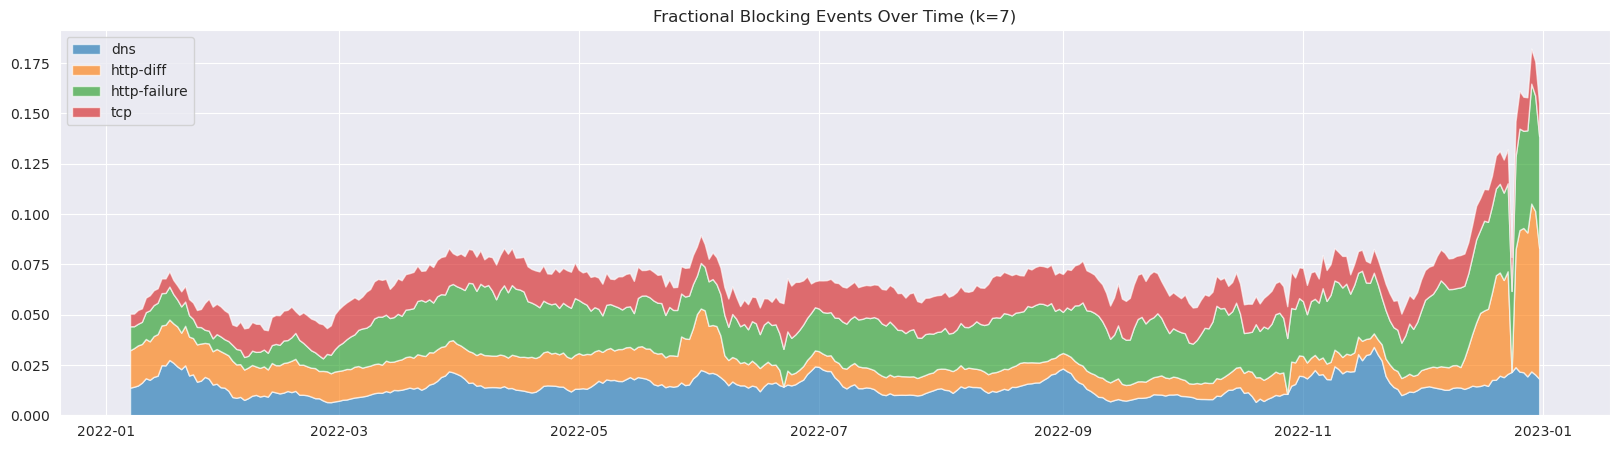

In [8]:
# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(total_events.index, frac_dns, frac_httpdiff, frac_httpfail, frac_tcp, labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events Over Time (k={k})')

Text(0.5, 1.0, 'Fractional Blocking Events From 2022-03-01-2022-05-01 (k=7)')

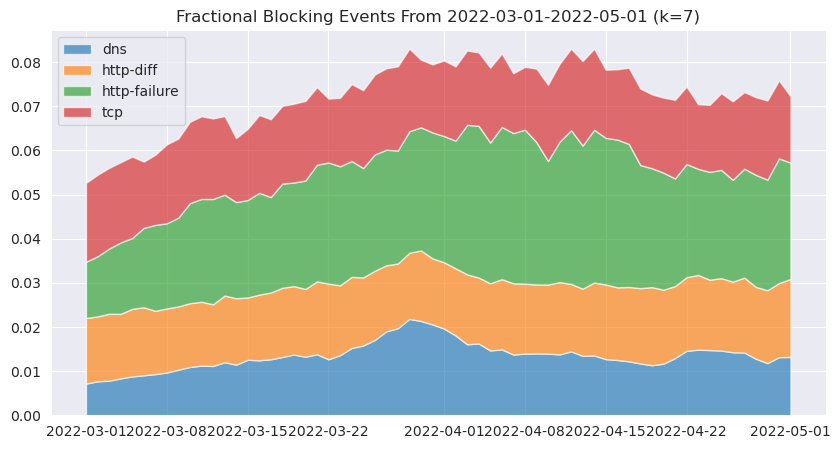

In [9]:
# Zoom in on a region of interest
start_date = '2022-03-01'
end_date = '2022-05-01'
filter_range = total_events.index[(total_events.index >= start_date) & (total_events.index <= end_date)]
plt.rcParams['figure.figsize'] = [10, 5]
plt.stackplot(filter_range, frac_dns[filter_range], frac_httpdiff[filter_range], frac_httpfail[filter_range], frac_tcp[filter_range], labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events From {start_date}-{end_date} (k={k})')

In [10]:
# Extract known blocking methods
web_maybe_blocked = web_connectivity.loc[(web_connectivity['blocking'] != 'False') & (~web_connectivity['blocking'].isnull())]
web_maybe_blocked = web_maybe_blocked.sort_values(by=["input", "date"])
wmbi = web_maybe_blocked.set_index(['input', web_maybe_blocked.index])
wmbi

probe_asn control_failure  \
input                          date                                   
0.39:9131/tor/server/authority 2022-01-26   AS42772             NaN   
                               2022-01-26    AS6697             NaN   
                               2022-01-26    AS6697             NaN   
                               2022-01-26   AS42772             NaN   
                               2022-01-26   AS42772             NaN   
...                                             ...             ...   
zzn.com/                       2022-12-20    AS6697             NaN   
                               2022-12-22    AS6697             NaN   
                               2022-12-26    AS6697             NaN   
                               2022-12-27    AS6697             NaN   
                               2022-12-29    AS6697             NaN   

                                          body_length_match accessible  \
input                          date                                      
0.39:9131/tor/server/authority 2022-01-26               NaN      False   
                               2022-01-26               NaN      False   
                               2022-01-26               NaN      False   
                               2022-01-26               NaN      False   
                               2022-01-26               NaN      False   
...                                                     ...        ...   
zzn.com/                       2022-12-20             False      False   
                               2022-12-22             False      False   
                               2022-12-26             False      False   
                               2022-12-27             False      False   
                               2022-12-29             False      False   

                                          resolver_asn dns_consistency  \
input                          date                                      
0.39:9131/tor/server/authority 2022-01-26      AS15169      consistent   
                               2022-01-26          AS0      consistent   
                               2022-01-26      AS14618      consistent   
                               2022-01-26         AS42      consistent   
                               2022-01-26      AS15169      consistent   
...                                                ...             ...   
zzn.com/                       2022-12-20       AS6697      consistent   
                               2022-12-22       AS6697      consistent   
                               2022-12-26       AS6697      consistent   
                               2022-12-27       AS6697      consistent   
                               2022-12-29       AS6697      consistent   

                                           x_null_null_flags  \
input                          date                            
0.39:9131/tor/server/authority 2022-01-26                NaN   
                               2022-01-26                NaN   
                               2022-01-26                NaN   
                               2022-01-26                NaN   
                               2022-01-26                NaN   
...                                                      ...   
zzn.com/                       2022-12-20                NaN   
                               2022-12-22                NaN   
                               2022-12-26                NaN   
                               2022-12-27                NaN   
                               2022-12-29                NaN   

                                          status_code_match title_match  \
input                          date                                       
0.39:9131/tor/server/authority 2022-01-26               NaN         NaN   
                               2022-01-26               NaN         NaN   
                               2022-01-26               NaN

In [11]:
# Find sites with largest number of blocking events
topw = wmbi.groupby(level=0).size().sort_values(ascending=False)
topw

input
intex-press.by/                                         1641
torproject.org/                                         1613
spring96.org/                                           1590
vitebsk.cc/                                             1176
dw.com/                                                 1112
                                                        ... 
1.3/dns-query                                              1
facebook.com/people/Volnae-Hlybokaye/100015141876446       1
1and1.com/                                                 1
xiaomi.com/pass/serviceLogin                               1
1.1/dns-query                                              1
Length: 1710, dtype: int64

In [12]:
# Get data from the top blocking events
wmbi.loc[topw[topw > 10].index]

probe_asn control_failure body_length_match  \
input               date                                                     
intex-press.by/     2022-01-02    AS6697             NaN             False   
                    2022-01-03   AS42772             NaN             False   
                    2022-01-03    AS6697             NaN               NaN   
                    2022-01-03   AS42772             NaN             False   
                    2022-01-04   AS42772             NaN             False   
...                                  ...             ...               ...   
livejournal.com/by/ 2022-12-20    AS6697             NaN             False   
                    2022-12-21    AS6697             NaN             False   
                    2022-12-22    AS6697             NaN             False   
                    2022-12-29    AS6697             NaN             False   
                    2022-12-30    AS6697             NaN             False   

                               accessible resolver_asn dns_consistency  \
input               date                                                 
intex-press.by/     2022-01-02      False      AS14618      consistent   
                    2022-01-03      False         AS42      consistent   
                    2022-01-03      False          AS0      consistent   
                    2022-01-03      False      AS49544      consistent   
                    2022-01-04      False          AS0      consistent   
...                                   ...          ...             ...   
livejournal.com/by/ 2022-12-20      False       AS6697      consistent   
                    2022-12-21      False       AS6697      consistent   
                    2022-12-22      False       AS6697      consistent   
                    2022-12-29      False       AS6697      consistent   
                    2022-12-30      False       AS6697      consistent   

                                x_null_null_flags status_code_match  \
input               date                                              
intex-press.by/     2022-01-02                NaN              True   
                    2022-01-03                NaN              True   
                    2022-01-03                NaN               NaN   
                    2022-01-03                NaN              True   
                    2022-01-04                NaN              True   
...                                           ...               ...   
livejournal.com/by/ 2022-12-20                NaN             False   
                    2022-12-21                NaN             False   
                    2022-12-22                NaN             False   
                    2022-12-29                NaN             False   
                    2022-12-30                NaN             False   

                               title_match      blocking  \
input               date                                   
intex-press.by/     2022-01-02         NaN     http-diff   
                    2022-01-03       False     http-diff   
                    2022-01-03         NaN  http-failure   
                    2022-01-03       False     http-diff   
                    2022-01-04       False     http-diff   
...                                    ...           ...   
livejournal.com/by/ 2022-12-20       False     http-diff   
                    2022-12-21       False     http-diff   
                    2022-12-22       False     http-diff   
                    2022-12-29       False     http-diff   
                    2022-12-30       False     http-diff   

                               dns_experiment_failure  x_blocking_flags  \
input               date                                                  
intex-press.by/     2022-01-02                    NaN               NaN   
                    2022-01-03                    NaN               NaN   
                    2022-01-03                  

In [13]:
# Group all events by input calculate totals
dns_grouped = dns_events.groupby('input').size() # sort_values(ascending=False)
httpdiff_grouped = httpdiff_events.groupby('input').size()
httpfail_grouped = httpfail_events.groupby('input').size()
tcp_grouped = tcp_events.groupby('input').size()
totals_grouped = web_connectivity.groupby('input').size()

In [14]:
# Calculate fraction of events blocked per input
frac_dns_grouped = (dns_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_httpdiff_grouped = (httpdiff_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_httpfail_grouped = (httpfail_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_tcp_grouped = (tcp_grouped / totals_grouped).dropna().sort_values(ascending=False)

In [15]:
# Get all events grouped by the type of blocking event
all_grouped = pd.DataFrame({'dns': frac_dns_grouped, 'httpdiff': frac_httpdiff_grouped, 'httpfail': frac_httpfail_grouped, 'tcp': frac_tcp_grouped}).fillna(0)
all_grouped

,dns,httpdiff,httpfail,tcp
input,,,,
0.39:9131/tor/server/authority,0.000000,0.000000,0.000000,0.898701
015.by/search/,0.071648,0.000000,0.000000,0.286592
1.1/dns-query,0.000000,0.000000,0.001129,0.000000
1.3/dns-query,0.000000,0.000000,0.001115,0.000000
100webspace.com/,0.000000,0.000000,0.001261,0.013871
...,...,...,...,...
zoomshare.com/,0.000000,0.000000,0.003567,0.015458
zubr.cc/,0.042650,0.000000,0.449183,0.000000
zubr.in/,0.083784,0.000000,0.404505,0.000000


In [16]:
# Extract the top N sites
nn = 100
top_n_idx = all_grouped.sum(axis=1).sort_values(ascending=False)[0:nn].index
top_n = all_grouped.loc[top_n_idx]
top_n

,dns,httpdiff,httpfail,tcp
input,,,,
hdrezka.ag,0.000000,0.0,1.000000,0.0
iwantim.com/,0.000000,0.0,0.000000,1.0
kinogo.zone,0.000000,0.0,1.000000,0.0
zerkalo.io,1.000000,0.0,0.000000,0.0
xiaomi.com/pass/serviceLogin,1.000000,0.0,0.000000,0.0
...,...,...,...,...
williamhill.com/,0.078431,0.0,0.470588,0.0
belsat.eu/ru/,0.121392,0.0,0.426995,0.0
politzek.me/,0.249438,0.0,0.298876,0.0


In [17]:
# Calculate cumulative values
c_top_n = top_n.cumsum(axis=1)

Text(0.5, 0, 'Fraction of events')

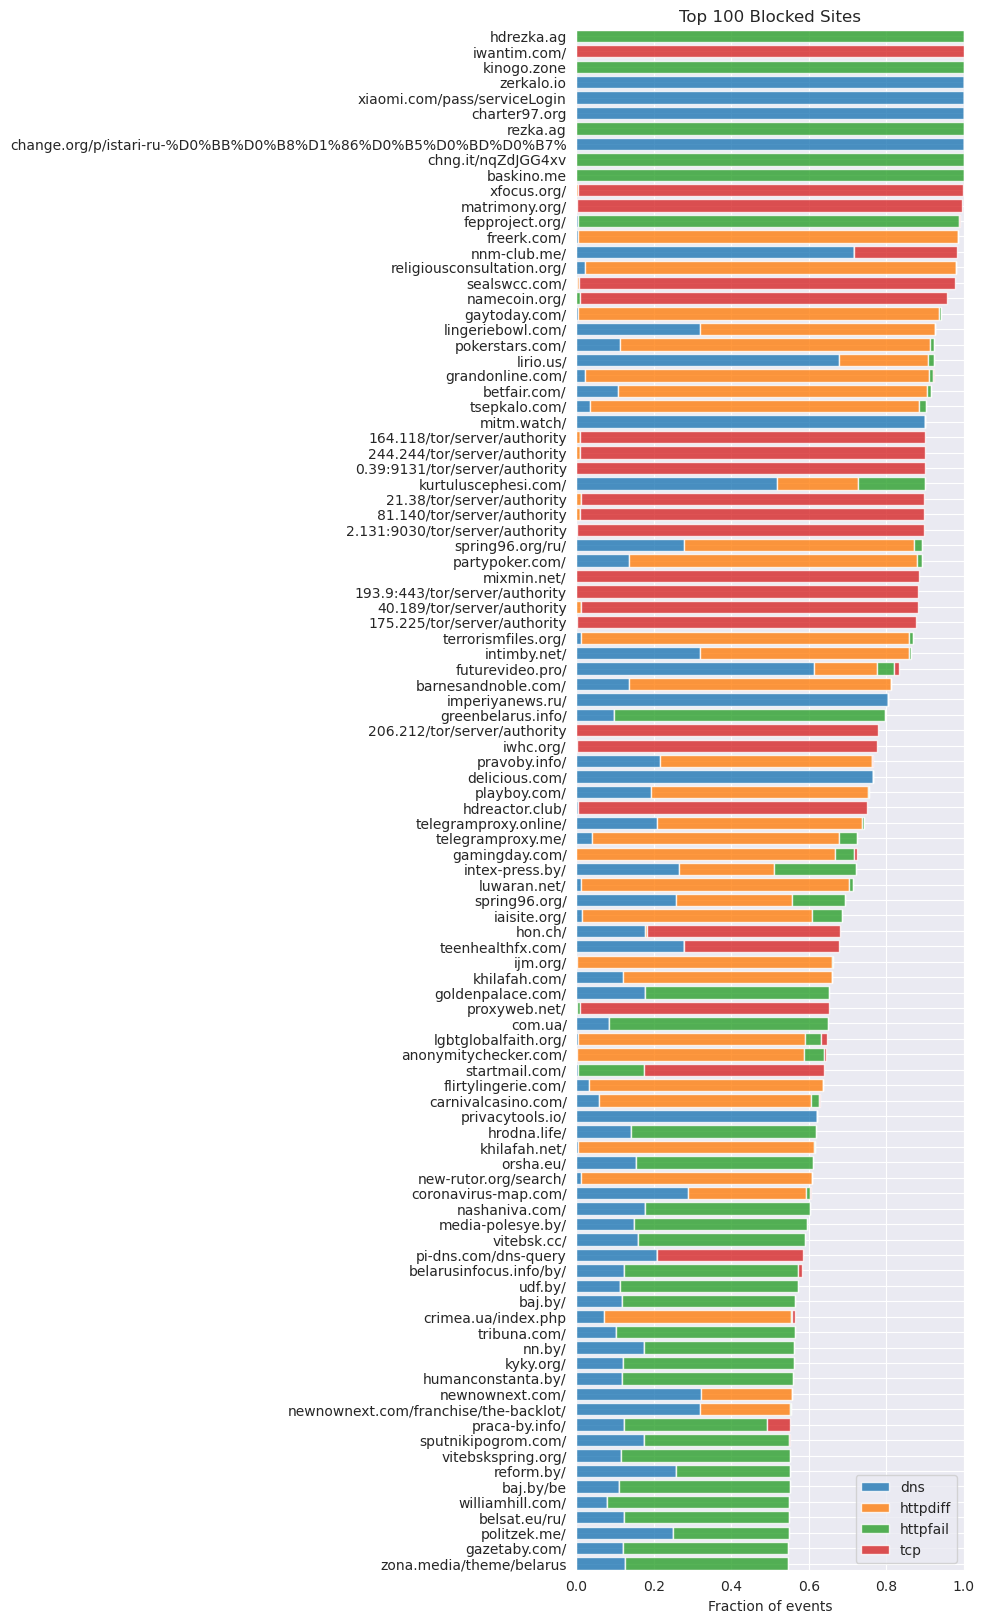

In [18]:
# Plot 
plt.rcParams['figure.figsize'] = [5, 20]
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['dns'].iloc[::-1], label='dns', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['httpdiff'].iloc[::-1], left=c_top_n.iloc[::-1,0], label='httpdiff', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['httpfail'].iloc[::-1], left=c_top_n.iloc[::-1,1], label='httpfail', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['tcp'].iloc[::-1], left=c_top_n.iloc[::-1,2], label='tcp', alpha=0.8)
plt.margins(y=0)
plt.legend()
plt.grid()
plt.title(f'Top {nn} Blocked Sites')
plt.xlabel('Fraction of events')